# Heart Failure Prediction

Kaggle excerpt:

>Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
    Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

>Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

>People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.


Data Source: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). Available at: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

## Dataset original features:
    - age: Age
    - anaemia: Decrease of red blood cells or hemoglobin (boolean - 0 = No, 1 = Yes)
    - creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L) [Used to investigate if there's tissues stress or damage)
    - diabetes: If the patient has diabetes (boolean - 0 = No, 1 = Yes)
    - ejection_fraction: Percentage of blood leaving the heart at each contraction (percentage)
    - high_blood_pressure: If the patient has hypertension (boolean - 0 = No, 1 = Yes)
    - platelets: Platelets in the blood (kiloplatelets/mL)
    - serum_creatinine: Level of serum creatinine in the blood (mg/dL) [waste product that comes from the normal wear and tear on muscles of the body]
    - serum_sodium: Level of serum sodium in the blood (mEq/L) [helps determine electrolite balancee renal function]
    - sex: Woman or man (binary - Male = 1, Female =0)
    - smoking: 0 = No, 1 = Yes
    - time: captures the time of the event. That is, the time at which the patient died or were censored.
    - DEATH_EVENT: encodes whether the patient died (1) or whether they were censored (0). Censoring means that the scientists lost contact with the patient.
        
Features descriptions gathered from kaggle "About this dataset" and "Discussion" sections. Additional information between '[]'.        

## Importing Packages

In [1]:
import os

import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import f_oneway



from IPython.core.display import display, HTML

## User Defined Functions

In [2]:
def chck_miss(df):
    '''Checking dataset for missing values distribution'''

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

In [3]:
def check_level(df):
    '''Checking dataset categorical features levels'''
    print("Checking the categories levels of categorical features: \n")
    for i in df.columns:
        if (df[i].dtype == object):
            print('These are the categories of \'',i,' \':\n',df[i].unique(), '\n')
    del i 
    

In [4]:
def check_duplicates(df,maintain='last'):
    '''Checking duplicate values in dataset'''
    
    res = df.duplicated().sum()
    print('There are', res , 'duplicated values in dataset.' )
    if res != 0 :
        df.drop_duplicates(keep = maintain,inplace=True)
        if maintain == 'last':
            print('Duplicated values were dropped maintaning only the last occurrence')
        else:
             print('Duplicated values were dropped maintaning only the first occurrence')

In [5]:
def uni_numerical(df,visual='Y',test='N',just_summr='N',alpha=0.05):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset. 
    Parameters: dataset,test(Shapiro('S'),Anderson-Darling('AD'), Kolmogorov-Smirnov('KS'), all('A') or None('N'), 
    plot visuals('Y' or 'N',default='Y'),significance level(alpha, default=0.05(0.15,0.1,0.05,0.025,0.01))), 
    just_summr if set to 'Y' will present just the normality tests assumptions (no other parameter will be 
    considered) and summary table with normality tests results for the data set('Y' or 'N',default='N')''' 

#Include The Anderson-Darling test for normality and table with summary an statistical and p-values for normality tests

    print('\nExploratory Data Analysis')
    print('\n############### Univariate analysis - Numerical ###############\n')
    print('\n\nFor normality tests of datasets with few variables, better perform a visual check,e.g: Q-Q plot.')
    print('\n\nFor large datasets, you can present just a summary of normality tests and and other measures values by setting parameter just_summr="y".\n\n')
    
    
    
# Importing packages
    from statsmodels.graphics.gofplots import qqplot
    from seaborn_qqplot import pplot
    import stemgraphic
    #https://github.com/fdion/stemgraphic/blob/master/doc/stemgraphic%20A%20Stem-and-Leaf%20Plot%20for%20the%20Age%20of%20Big%20Data.pdf
    
    from scipy.stats import norm
    from scipy.stats import kstest
    from scipy.stats import shapiro
    from scipy.stats import anderson
    
    
# Setting parameters
    test = test    
    alpha = alpha
    visual = visual
    just_summr = just_summr
    
    
    #For AD normality test - pvalues
    switcher = {0.15:0,
                0.1:1,
                0.05:2,
                0.025:3,
                0.01:4}
    
# Defining functions

    #stem-and-leaf plot
    def sl_plot(x,i):
        fig,ax = stemgraphic.graphic.stem_graphic(x,title='Stem-and_leaf plot for '+ str(i),asc=True,flip_axes=False,
                                                  mirror =False, legend_pos=None,delimiter_color='w',alpha=.5,
                                                  font_kw={'size':4},median_color='r',median_alpha=0.7,
                                                  primary_kw={'size_inches':(10, 15)},figure_only=True )
        #stemgraphic.stem_hist(x, color='b',delimiter_color='w',legend_pos=None)
        #fig, ax = stemgraphic.stem_graphic(x,flip_axes=True)
        #plt.title("Stem-and-Leaf plot for ",i)
        plt.show()


    #Normality tests
    def Kolmogorov(x,i):
        # The test statistic developed by Kolmogorov and Smirnov 
        # to compare distributions was simply the maximum vertical distance between the two functions
        x=x
        i=i
        
        print('Kolmogorov-Smirnov normality test\n')
        print('Mostly used with large samples (n > 50)') ####################### TO confirm!!!!!!!!!!
        print('Assumptions One-sample KS test:\n')
        print('1. The sample is a random sample')
        print('2. The theoretical distribution must be fully specified. The critical values given in tables ')
        print('   (and often by software packages) assume this to be the case. If parameters are estimated from the ')
        print('   data, the test result will be (much) too conservative. If parameters are estimated from the sample, ')
        print('   Lilliefors test should be used instead.) ')
        print('3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),')
        print('   the result will be too conservative, although Conover (1999) provides an equivalent approach for ')
        print('   discrete distributions for small samples.[Check Stem-and-leaf plot]')
        print('4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, ')
        print('   or if the variable under consideration is discrete), the result will be (much) too liberal as the ')
        print('   large steps give an excessively large d. A categorized distribution can be tested with ')
        print('   Kolmogorov-Smirnov by dividing observed differences between cumulative distributions by the number of ')
        print('   observations in the class interval (n). But such a test is too conservative given (a) the distribution')
        print('   is discrete (see above) and (b) power is reduced because the number of observations reduced by a ')
        print('   factor of n. \n')
        print('Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/')
        print('\n')
        
        stat, p_normal = kstest(x,'norm') 
        
        print('Kolmogorov-Smirnov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
        
        return p_normal

    
    def Shapiro(x):
        # The Shapiro test is based on the correlation between the data and the corresponding normal scores 
        
        print("\nShapiro's test\n")
        print('The Shapiro test is based on the correlation between the data and the corresponding normal scores.')
        print('As the dataset being evaluated gets larger, the Shapiro-Wilk test tends to be slightly more ')
        print(    'sensitive to data in the tails which leads to a greater probability of rejecting the null hypothesis ')
        print('Source: https://influentialpoints.com/Training/kolmogorov-smirnov_test-principles-properties-assumptions.htm')
        print('\n')
        
        stat, p_normal = shapiro(x) 
        
        print('Shapiro\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
        
        
        
        return p_normal
    
    def AnderDarlin(x):
        #Documentation:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
                
        print("\nAnderson-Darling's test\n")
        print('The Anderson-Darling test is severely affected by ties[check Stem-and-Leaf plot] in the data due to poor precision.') 
        print(    'When a significant number of ties exist, the Anderson-Darling will frequently reject the data ')
        print(    'as non-normal, regardless of how well the data fits the normal distribution.')
        print('If the returned statistic is larger than these critical values then for the corresponding significance level,')
        print(    'the null hypothesis that the data come from the chosen distribution can be rejected. ')
        print('Source: https://variation.com/wp-content/distribution_analyzer_help/hs140.htm')
        print('\n')
    
        stat, crit_values, sig = anderson(x,dist='norm') 
        
        #switcher = {0.15:0,
        #    0.1:1,
        #    0.05:2,
        #    0.025:3,
         #   0.01:4}

        def switch(alpha1) :
            alpha1=alpha1
            return switcher.get(alpha1)
        
        idx=switch(alpha)
        print('Anderson-Darling\'s Statistics=%.3f, critical value=%.3f' % (stat, crit_values[idx]))
        
        print('\nHypothesis:')
        print('\nH0: Sample may be Gaussian')
        print('H1: Sample does not looks Gaussian ')
        
        print('\nSignificance level:',alpha)
        
        if stat > crit_values[idx]:
            print('\nNormality\'s test result: Sample does not look Gaussian (reject H0)\n\n')
        else:
            print('\nNormality\'s test result: Sample looks Gaussian (fail to reject H0)\n\n')
   
    
    def normal_test(x,i):
        #x =  feature, i = feature's name
        '''Normality test for a feature'''
    # normality test
        print('\n############### Normality tests ###############\n')
        i = i
        x =  x  
        #print("Normality test for: ",i,"\n")
        #stat, p_normal = shapiro(df[i])
        if test == 'KS':
            sl_plot(x,i)
            p_normal = Kolmogorov(x,i) 
            # interpretation
            interp(p_normal)
        elif test == 'S':
            p_normal = Shapiro(x)
            # interpretation
            interp(p_normal)
        elif test == 'AD':
            sl_plot(x,i)
            p_normal = AnderDarlin(x)
               
        else:
            #test
            sl_plot(x,i)
            p_normal = Kolmogorov(x,i) 
            # interpretation
            interp(p_normal)
            print('___________________________\n\n')   
            #test
            p_normal = AnderDarlin(x)
            print('___________________________\n\n') 
            #test
            p_normal = Shapiro(x)
            # interpretation
            interp(p_normal)

                
        print('_____________________________________________________________________________\n\n')
        
        
    def interp(p_norm):
        '''This function presents interpretation for normality test p-value'''
        p_normal = p_norm
        # interpretation
        print('\nHypothesis:')
        print('\nH0: Sample may be Gaussian')
        print('H1: Sample does not looks Gaussian ')
        
        print('\nSignificance level:',alpha)
        
        if p_normal > alpha:
            print('\nNormality\'s test result: Sample looks Gaussian (fail to reject H0)\n\n')
        else:
            print('\nNormality\'s test result: Sample does not look Gaussian (reject H0)\n\n')
        
    def visual_plot(x,i):
        #x =  feature, i = feature's name
        '''This function presents visuals for Uninumerical EDA'''
        features = x
        i = i
    # Visualization
        # Histogram and Boxplot
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(10, 6.5)
    #   sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.histplot(x=x, kde=True, ax=ax_hist)
        sns.boxplot(x=x, ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        f.suptitle("Plots for "+ str(i))
        plt.show()
        
        #Q-Q plot (against a normal distribution)
         
        pplot(df, x=i, y=norm, kind='qq',height=8,display_kws={"identity":True})
        plt.title("QQ Plot")
        plt.show()
        print('_____________________________________________________________________________\n\n')

        
        
        
    def sumr(x):
        '''This function presents summary for Uninumerical EDA'''
    # Setting canvas  
        sns.color_palette("dark")    #, as_cmap=True
        sns.set_context("talk", font_scale=1) #paper, notebook, talk, poster
    # Summarization   
        table = pd.DataFrame() #table to summarise tests statitics and measures
        
        KolmogorovStat=[]
        KolmogorovPval=[]
        
        ADStat=[]
        ADCrit=[]
        
        ShapiroStat=[]
        ShapiroPval=[]
        
        
        df.describe()
        Summary = dict(df.describe())
        features = []
        for i in Summary:
            Summary[i]['count'] = df[i].count()
            Summary[i]['variance'] = df[i].var()
            Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
            Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
            Summary[i]['skewness'] = df[i].skew()
            Summary[i]['kurtosis'] = df[i].kurtosis()
            Summary[i]['mode'] = df[i].mode().values #axis='columns'
            #print('\n This is univariate analysis for',"'", i, "'", '\n\n')
           # print('############### Summary ###############')
            #display(pd.DataFrame(Summary[i]))
            

            #KS values
            features.append(i)
            table = table.append(Summary[i], ignore_index=True)
            stat, p_normal = kstest(df[i],'norm') 
            KolmogorovStat.append(stat)
            KolmogorovPval.append(p_normal)
                
            #AD values
            stat, crit_values, sig = anderson(df[i],dist='norm') 
        
            def switch(alpha1) :
                alpha1=alpha1
                return switcher.get(alpha1)
        
            idx=switch(alpha)
            stat, crit_values = stat, crit_values[idx]
        
            ADStat.append(stat)
            ADCrit.append(crit_values)
                
                
            #S values
            stat, p_normal = shapiro(df[i])
            ShapiroStat.append(stat)
            ShapiroPval.append(p_normal)
            
            if just_summr != 'Y':   
                print('\n This is univariate analysis for',"'", i, "'", '\n\n')
                print('############### Summary ###############')
                display(pd.DataFrame(Summary[i]))
            
                if test != 'N' and visual == 'N':
                    normal_test(df[i],i) 
                elif test != 'N' and visual == 'Y':
                    normal_test(df[i],i)                 
                    visual_plot(df[i],i)
                elif test == 'N' and visual == 'Y':    
                    visual_plot(df[i],i)

        table = pd.concat([table,pd.DataFrame(features,columns=['features'])],axis=1, ignore_index=False)
        table['Defined Significance Level'] = alpha
        
        table = pd.concat([table,pd.DataFrame(KolmogorovStat,columns=['Kolmogorov Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(KolmogorovPval,columns=['Kolmogorov P-value'])],axis=1, ignore_index=False)
        
        table = pd.concat([table,pd.DataFrame(ADStat,columns=['Anderson-Darling Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(ADCrit,columns=['Anderson-Darling Critical Value'])],axis=1, ignore_index=False)
        
        table = pd.concat([table,pd.DataFrame(ShapiroStat,columns=['Shapiro Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(ShapiroPval,columns=['Shapiro P-value'])],axis=1, ignore_index=False)
         
        if just_summr != 'Y':   
            print('\n This is univariate analysis for',"'", i, "'", '\n\n')
            print('############### Summary ###############')
            display(pd.DataFrame(Summary[i]))
            
            if test != 'N' and visual == 'N':
                normal_test(df[i],i) 
            elif test != 'N' and visual == 'Y':
                normal_test(df[i],i)                 
                visual_plot(df[i],i)
            elif test == 'N' and visual == 'Y':    
                visual_plot(df[i],i)
              
        
        print('############### Summary ###############\n')    
        
        print('\nHypothesis:')
        print('\nH0: Sample may be Gaussian')
        print('H1: Sample does not looks Gaussian \n ')
        
        print('Kolmogorov-Smirnov normality test\n')
        print('Mostly used with large samples (n > 50)') ####################### TO confirm!!!!!!!!!!
        print('Assumptions One-sample KS test:\n')
        print('1. The sample is a random sample')
        print('2. The theoretical distribution must be fully specified. The critical values given in tables ')
        print('   (and often by software packages) assume this to be the case. If parameters are estimated from the ')
        print('   data, the test result will be (much) too conservative. If parameters are estimated from the sample, ')
        print('   Lilliefors test should be used instead.) ')
        print('3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),')
        print('   the result will be too conservative, although Conover (1999) provides an equivalent approach for ')
        print('   discrete distributions for small samples.[Check Stem-and-leaf plot]')
        print('4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, ')
        print('   or if the variable under consideration is discrete), the result will be (much) too liberal as the ')
        print('   large steps give an excessively large d. A categorized distribution can be tested with ')
        print('   Kolmogorov-Smirnov by dividing observed differences between cumulative distributions by the number of ')
        print('   observations in the class interval (n). But such a test is too conservative given (a) the distribution')
        print('   is discrete (see above) and (b) power is reduced because the number of observations reduced by a ')
        print('   factor of n. \n')
        print('Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/')
        print('\n')        
        
        print("\nAnderson-Darling's test\n")
        print('The Anderson-Darling test is severely affected by ties[check Stem-and-Leaf plot] in the data due to poor precision.') 
        print(    'When a significant number of ties exist, the Anderson-Darling will frequently reject the data ')
        print(    'as non-normal, regardless of how well the data fits the normal distribution.')
        print('\nIf the returned statistic is larger than these critical values then for the corresponding significance level,')
        print(    'the null hypothesis that the data come from the chosen distribution can be rejected. \n')
        print('Source: https://variation.com/wp-content/distribution_analyzer_help/hs140.htm')
        print('\n')
    
        print("\nShapiro's test\n")
        print('The Shapiro test is based on the correlation between the data and the corresponding normal scores.')
        print('As the dataset being evaluated gets larger, the Shapiro-Wilk test tends to be slightly more ')
        print(    'sensitive to data in the tails which leads to a greater probability of rejecting the null hypothesis \n')
        print('Source: https://influentialpoints.com/Training/kolmogorov-smirnov_test-principles-properties-assumptions.htm\nhttps://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html\n')
        print('\n')
        
        
        print('Summary table for Data set')
        display(table[['features', 'count', 'mean', 'std', 'min', '25%','50%', '75%', 'max', 'variance', 'IQR', 'range', 'skewness', 'kurtosis', 'mode', 'Kolmogorov Statistics', 'Kolmogorov P-value', 'Anderson-Darling Statistics', 'Anderson-Darling Critical Value', 'Shapiro Statistics', 'Shapiro P-value', 'Defined Significance Level']])
        
        
    sumr(df)

In [6]:
def uni_categorical(df,# data frame, if variable inform as df[[var]]
                    size=None,# size of the plot to be create: "L" large,otherwise Small
                    label=None, #if the bar plot should have labels and ticks
                    ref=None, # ref add a y-axis reference line inform value
                   ):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
# Setting canvas  
    sns.color_palette("dark")    #, as_cmap=True
    sns.set_context("talk", font_scale=0.8) #paper, notebook, talk, poster

    #extracting only non-numerical features
    df = df.select_dtypes(exclude=np.number) 
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts(dropna=False)
            d2 = round(df[i].value_counts(normalize=True,dropna=False)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            d1[i]=d1[i].fillna('Missing') 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(22, 10)
            else:
                fig.set_size_inches(8, 8)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)#,color='darkblue'
            if label == 'Y':
                for p in ax.patches:
                    ax.annotate(int(p.get_height()), 
                    (p.get_x()+p.get_width()/2+.3, p.get_height()),        
                    ha='center',va='center',xytext=(2, 10),textcoords='offset points', rotation=45)
            else:
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected,'major', 'minor', 'both'
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
            plt.xticks(rotation=45, ha='right') 
            if ref != None:
                plot1.axhline(ref,c='red',label='threshold='+str(ref),linestyle='--')
                plt.legend(loc=1)
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

In [7]:

def bi_categorical_cat(df, alpha):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of categorical
    x categorical features. df, alpha(significance level)'''
    
    print('\n############### Bivariate analysis - Categorical x Categorical ###############\n')
    
    print("Chi-square tests, or similar resampling simulations, are used in data science applications more as a filter")
    print("\t to determine whether an effect or feature is worthy of further consideration than as a formal test of ")
    print("\t significance \n[...] \nThey can also be used in automated feature selection in machine learning, to assess ")
    print("\t class prevalence  across features and identify features where the prevalence of a certain class is ")
    print("\t unusually high or low, in a way that is not compatible with random variation. \n")
    print("Source: Practical Statistics for Data Scientists ")
    print("\t by Peter Bruce and Andrew Bruce ")
    print("\t Published by O’Reilly Media\n\n")
    
# importing packages 
    from scipy.stats.contingency import chi2_contingency
    
# Setting parameters
    df = df
    alpha = alpha
    
# Setting canvas  
    sns.set_theme(style="white")
    sns.color_palette("dark")    #, as_cmap=True
    sns.set_context("talk", font_scale=0.8) #paper, notebook, talk, poster
    
# Getting categorical features
    categorical_columns = df.select_dtypes(exclude=np.number) 
   
# Background color for summary
    def color1(val):
        if val == "Reject Null Hypothesis. There's some correlation between variables":
            #color = 'red'
            return 'background-color: red' #% color

# Analysis     
    elements = []
    table = pd.DataFrame() #table to summarise tests statitics and measures 
    features=[]
    dof_list= []
    pval_list=[]
    res = []
#analysis = pd.DataFrame()
    for i in categorical_columns:
        elements.append(i)
        for j in categorical_columns:
            if j in elements:
                continue
            else: 
                contigency_table = pd.crosstab(categorical_columns[i],categorical_columns[j])
            
                print('This is contingency table for: '+ str(categorical_columns[i].name)+ ' and ' +str(categorical_columns[j].name)+'\n\n' ,contigency_table,'\n')

                alpha = 0.05
                chi_2, p_val, dof, exp_val = chi2_contingency(contigency_table)
                contigency_table.plot(kind='bar',figsize=(8,3))
                plt.title('Bivariate Analysis: ' + str(categorical_columns[i].name) +' vs ' + str(categorical_columns[j].name))
#     plt.ylim(0,3500)
                plt.legend(ncol=2,fontsize=10,title=str(categorical_columns[j].name),title_fontsize='x-small',
                          loc='best') # bbox (x, y, width, height) , bbox_to_anchor=(0, 0.5,1,1))
                plt.show()
    
                print('\nChi-square\'s Null hypothesis: There\'s no correlation between variables.')
                print("\nChi-square's results:")
                if p_val > alpha:
                    res_aux = "Fail to reject Null Hypothesis. There's no correlation between variables"
                    print('DOF: ',dof,'\np-value= ',p_val,"\n Fail to reject Null Hypothesis. There's no correlation between variables at ",alpha," significance level.")
                    print('\n\n__________________________________________________________________________________________\n\n')
                    
                    features.append([str(categorical_columns[i].name) + ' and ' +  str(categorical_columns[j].name)])
                    dof_list.append(dof)
                    pval_list.append(p_val)
                    res.append(res_aux)
    
                else:
                    res_aux = "Reject Null Hypothesis. There's some correlation between variables"
                    print('DOF: ',dof,'\np-value= ',p_val,"\n\nReject Null Hypothesis. There's some correlation between variables at ",alpha," significance level.") 
                    print('\n\n__________________________________________________________________________________________\n\n')
                    features.append([str(categorical_columns[i].name) + ' and ' +  str(categorical_columns[j].name)])
                    dof_list.append(dof)
                    pval_list.append(p_val)
                    res.append(res_aux)
                    
    table = pd.concat([table,pd.DataFrame(features,columns=['features'])],axis=1, ignore_index=False)
    table = pd.concat([table,pd.DataFrame(dof_list,columns=['DOF'])],axis=1, ignore_index=False)
    table = pd.concat([table,pd.DataFrame(pval_list,columns=['P values'])],axis=1, ignore_index=False)
    table['Defined significance Level'] = round(alpha,5)
    table = pd.concat([table,pd.DataFrame(res,columns=['Result'])],axis=1, ignore_index=False)
    print('Summary of Results for Chi-Square test for Data set')
    
    display(table.style.applymap(color1, subset=['Result']))
                    

In [8]:
def bi_numerical_num(df):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of numerical x numerical features. '''

    def hoeffding(*arg):
    #Source: https://github.com/PaulVanDev/HoeffdingD     
    
        import pandas as pd
        import numpy as np
        from scipy.stats import rankdata
        from scipy.signal import decimate
        import math
        import time
        import matplotlib.pyplot as plt
        from sklearn.preprocessing import KBinsDiscretizer
        import warnings
        warnings.filterwarnings("ignore", category=UserWarning)
  
        if(len(arg)==1):
          if isinstance(arg[0], pd.DataFrame):
            if(arg[0].shape[0]>1):
              return arg[0].apply(lambda x: arg[0].apply(lambda y: hoeffding(x.values, y.values)))
        else:
          if(len(arg)==2):
            if type(arg[0]) is not np.ndarray:
              if (len(arg[0].shape)>1):
                return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
            if type(arg[1]) is np.ndarray:
              if (len(arg[0].shape)>1):
                return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
        
            xin=arg[0]
            yin=arg[1]
            #crop data to the smallest array, length have to be equal
            if len(xin)<len(yin):
              yin=yin[:len(xin)]
            if len(xin)>len(yin):
              xin=xin[:len(yin)]

            # dropna
            x = xin[~(np.isnan(xin) | np.isnan(yin))]
            y = yin[~(np.isnan(xin) | np.isnan(yin))]

            # undersampling if length too long
            lenx=len(x)
            if lenx>99999:
                factor=math.ceil(lenx/100000)
                x=x[::factor]
                y=y[::factor]

            # bining if too much "definition"
            if len(np.unique(x))>50:
                est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
                est.fit(x.reshape(-1, 1))  
                Rtemp = est.transform(x.reshape(-1, 1))
                R=rankdata(Rtemp)
            else:
                R=rankdata(x)
            if len(np.unique(y))>50:
                est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
                est1.fit(y.reshape(-1, 1))  
                Stemp = est1.transform(y.reshape(-1, 1))
                S=rankdata(Stemp)
            else:
                S=rankdata(y)      

            # core processing
            N=x.shape
            dico={(np.nan,np.nan):np.nan}
            dicoRin={np.nan:np.nan}
            dicoSin={np.nan:np.nan}
            dicoRless={np.nan:np.nan}
            dicoSless={np.nan:np.nan}
            Q=np.ones(N[0])

            i=0;
            for r,s in np.nditer([R,S]):
                r=float(r)
                s=float(s)
                if (r,s) in dico.keys():
                    Q[i]=dico[(r,s)]
                else:
                  if r in dicoRin.keys():
                      isinR=dicoRin[r]
                      lessR=dicoRless[r]
                  else:
                      isinR=np.isin(R,r)
                      dicoRin[r]=isinR
                      lessR=np.less(R,r)
                      dicoRless[r]=lessR

                  if s in dicoSin.keys():
                      isinS=dicoSin[s]
                      lessS=dicoSless[s]
                  else:
                      isinS=np.isin(S,s)
                      dicoSin[s]=isinS
                      lessS=np.less(S,s)
                      dicoSless[s]=lessS


                  Q[i] = Q[i] + np.count_nonzero(lessR & lessS) \
                        + 1/4 * (np.count_nonzero(isinR & isinS)-1) \
                        + 1/2 * (np.count_nonzero(isinR & lessS)) \
                         + 1/2 * (np.count_nonzero(lessR & isinS)) 
                  dico[(r,s)]=Q[i]
                i+=1

            D1 = np.sum( np.multiply((Q-1),(Q-2)) );
            D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
            D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );

            D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));

            return D
          return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
    
    
    
# Filter warnings
    warnings.filterwarnings('ignore',category=DeprecationWarning)#'always'    
    
    print('############### Bivariate analysis - Numerical x Numerical ###############')
    
    # Printing Assumptions/What tests for:
    
    #Pearson
    print('\nPearson Correlation (how strong the correlation is?):\n Null hypothesis: there’s no association between variables.')
    print('\t1.Normal distribution for both variables for pearson;')
    print('\t2.homoscedasticity assumes that data is equally distributed about the regression line.')
    print('\t3.Assess Linear relationship')
    
    #Spearman      
    print('\nSpearman rank Correlation (how strong the correlation is?):\n Null hypothesis: there’s no association between variables.')
    print('\t1.Data must be at least ordinal;')
    print('\t2.scores on one variable must be monotonically related to the other variable')     
    print("\t3.It's is appropriate for both continuous and discrete ordinal variables.")
    print("\t4.Assess monotonic relationships.")
    
    #Hoeffding      
    print("\nHoeffding's independence test(are the variables dependent?):\n Null hypothesis: there’s no association between variables.')")
    print('\t1.continuous distribution functions;')
    print('\t2. [...]the D statistic values are between –0.5 and 1, with 1 indicating complete dependence')     
    print("\t3. it has more power to detect non-monotonic dependency structures compared to other more common measures (Pearson, Kendall, Spearman)")
    print("\t4.Assess non-monotonic non-linear relationships.")
    print('Source: https://github.com/PaulVanDev/HoeffdingD')
    print('\thttps://blogs.sas.com/content/iml/2021/04/28/compute-hoeffding-d-statistic.html')
          

# Verifying datatypes extract only numerics
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df = df.select_dtypes(include=np.number)
    
# # correlation test (summary)
    #print('\nThis is Pearson\'s correlation:')
    #display(df.corr(method='pearson'))
    #print('\nThis is Spearman\'s correlation:')
    #display(df.corr( method='spearman'))
    #print('\nThis is Spearman\'s correlation:')
    #display(hoeffding(df))
    
# Visualization
    #scatter plot
    g= sns.PairGrid(df, corner=True,despine=True)      
    g.map_lower(sns.scatterplot, s=12)  
    g.map_lower(sns.lineplot, color='r')
    g.map_diag(sns.histplot)
    g.fig.suptitle('Numeric Features - Scatterplots and Histograms')
    plt.show()      
     
          
    #Pearson
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.set_palette("dark") # colorblind   pastel
    sns.set(style="whitegrid") #whitegrid ticks
    sns.heatmap(round(df.corr(method='pearson'),2),annot=True, annot_kws={"fontsize":11},linewidths=0.01,mask=mask)
    plt.suptitle('Pearson correlation')
    plt.show()
    
    
    #Spearman
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.set_palette("dark") # colorblind   pastel
    sns.set(style="whitegrid") #whitegrid ticks
    sns.heatmap(round(df.corr(method='spearman'),2),annot=True, annot_kws={"fontsize":11},linewidths=0.01,mask=mask)
    plt.title('Spearman correlation')
    plt.show()
    
    #Hoeffding
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.set_palette("dark") # colorblind   pastel
    sns.set(style="whitegrid") #whitegrid ticks
    sns.heatmap(round(hoeffding(df),2),annot=True, annot_kws={"fontsize":11},linewidths=0.01,mask=mask)
    plt.title("Hoeffding 's independence test")
    plt.show()

#### Setting cell size for better visualization

In [9]:
display(HTML("<style>div.output_scroll { height: 99em; }</style>"))

### Setting warnings OFF/ON

In [10]:
warnings.filterwarnings('always')#'ignore'

#Set theme for plots
sns.set_theme(style="white")

## Loading Dataset

In [11]:
# Changing Directory
os.chdir(r'D:\Cursos\Repositories\Heart_Failure_Prediction\Data\Raw Data\archive')

df = pd.read_csv('heart_failure_clinical_records_dataset.csv',dtype={'anaemia':str, 
                                                                     'diabetes':str, 
                                                                     'high_blood_pressure':str, 
                                                                     'sex':str,
                                                                     'smoking':str, 
                                                                     'DEATH_EVENT':str})

In [12]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


First look at dataset:

In [13]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [14]:
print('Shape of dataset: ',df.shape)

Shape of dataset:  (299, 13)


In [15]:
print('Features types:\n ',df.dtypes) 

Features types:
  age                         float64
anaemia                      object
creatinine_phosphokinase      int64
diabetes                     object
ejection_fraction             int64
high_blood_pressure          object
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                          object
smoking                      object
time                          int64
DEATH_EVENT                  object
dtype: object


Checking for missing values:

## Splitting Data set

Setting target and dividing training and test datasets:

In [16]:
target='DEATH_EVENT'

# Creating copy of df for exploration data analysis:
df_exp = df.copy()

X = df_exp.drop([target],axis=1)
y = df_exp[target]

# Dividing into training and test datasets:

X_train, X_test,y_train,y_test = train_test_split(X,y,random_state=8,test_size=0.3)

# Merging X and y to perform exploratory data analysis

df_exp = pd.concat([X_train, y_train], axis=1, join='inner')

## Exploratory Data Analysis

Exploratory data analysis will be performed only on train data to get the most unbiased estimate

### Univariate



In [17]:
chck_miss(df_exp)

Are there any missing value?
                          Total  # Missing  % Missing
DEATH_EVENT                 209          0        0.0
age                         209          0        0.0
anaemia                     209          0        0.0
creatinine_phosphokinase    209          0        0.0
diabetes                    209          0        0.0
ejection_fraction           209          0        0.0
high_blood_pressure         209          0        0.0
platelets                   209          0        0.0
serum_creatinine            209          0        0.0
serum_sodium                209          0        0.0
sex                         209          0        0.0
smoking                     209          0        0.0
time                        209          0        0.0


There are no missing values in this dataset.

### Checking categorical features

In [18]:
check_level(df_exp)

Checking the categories levels of categorical features: 

These are the categories of ' anaemia  ':
 ['0' '1'] 

These are the categories of ' diabetes  ':
 ['1' '0'] 

These are the categories of ' high_blood_pressure  ':
 ['0' '1'] 

These are the categories of ' sex  ':
 ['1' '0'] 

These are the categories of ' smoking  ':
 ['0' '1'] 

These are the categories of ' DEATH_EVENT  ':
 ['0' '1'] 



#### Recoding values to original meaning to make interpretation meaningful:



In [19]:
df_exp['anaemia'] = df_exp['anaemia'].map({'0':'No','1':'Yes'})
df_exp['diabetes'] = df_exp['diabetes'].map({'0':'No','1':'Yes'})
df_exp['high_blood_pressure'] = df_exp['high_blood_pressure'].map({'0':'No','1':'Yes'})
df_exp['sex'] = df_exp['sex'].map({'0':'Female','1':'Male'})
df_exp['smoking'] = df_exp['smoking'].map({'0':'No','1':'Yes'})
df_exp['DEATH_EVENT'] = df_exp['DEATH_EVENT'].map({'0':'Censored','1':'Died'})


In [20]:
check_duplicates(df_exp)

There are 0 duplicated values in dataset.


############### Univariate analysis - Categorical ###############

This is univariate analysis for ' anaemia ' 
      Count  Percentage
No     118       56.46
Yes     91       43.54


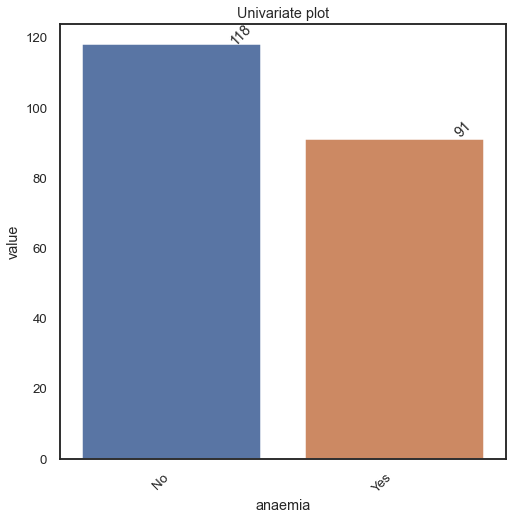


This is univariate analysis for ' diabetes ' 
      Count  Percentage
No     124       59.33
Yes     85       40.67


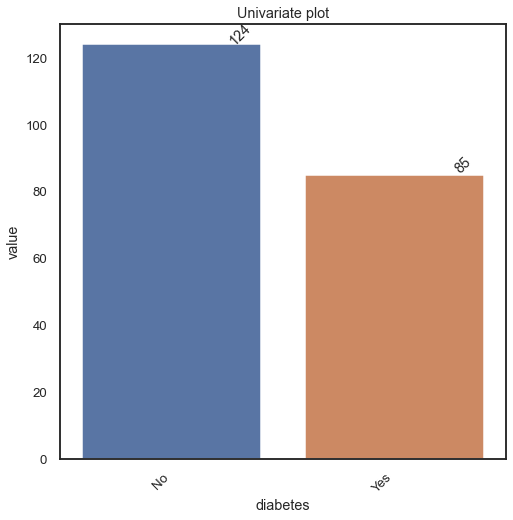


This is univariate analysis for ' high_blood_pressure ' 
      Count  Percentage
No     138       66.03
Yes     71       33.97


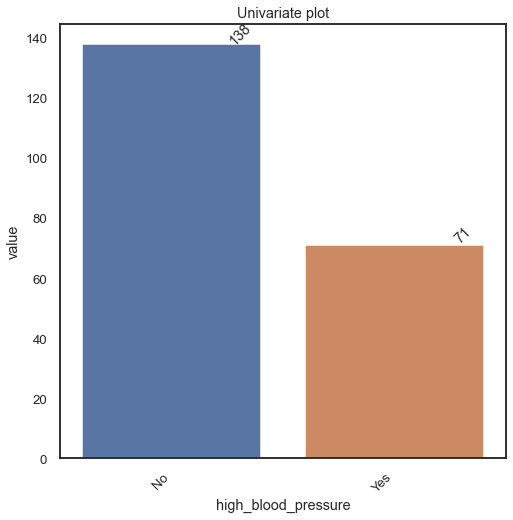


This is univariate analysis for ' sex ' 
         Count  Percentage
Male      130        62.2
Female     79        37.8


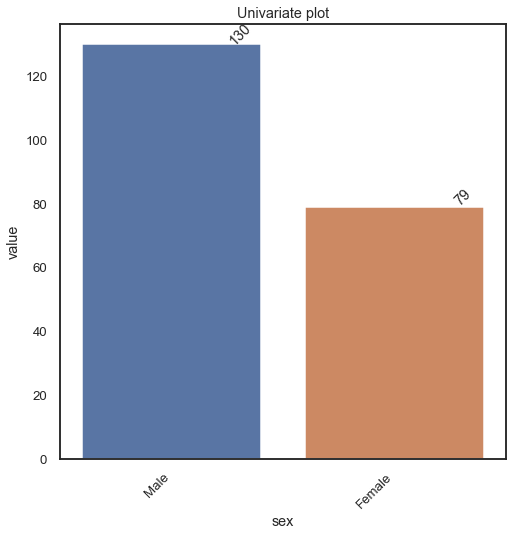


This is univariate analysis for ' smoking ' 
      Count  Percentage
No     143       68.42
Yes     66       31.58


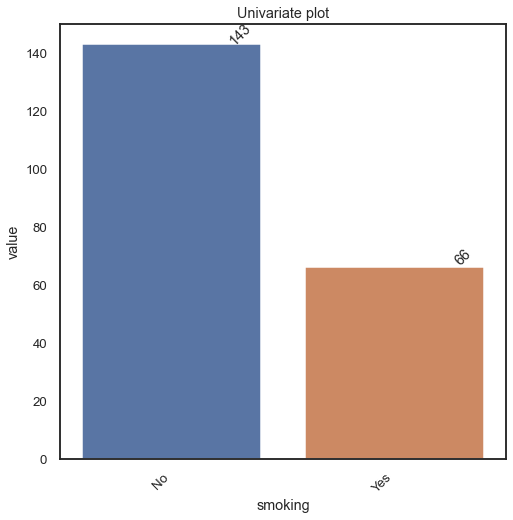


This is univariate analysis for ' DEATH_EVENT ' 
           Count  Percentage
Censored    136       65.07
Died         73       34.93


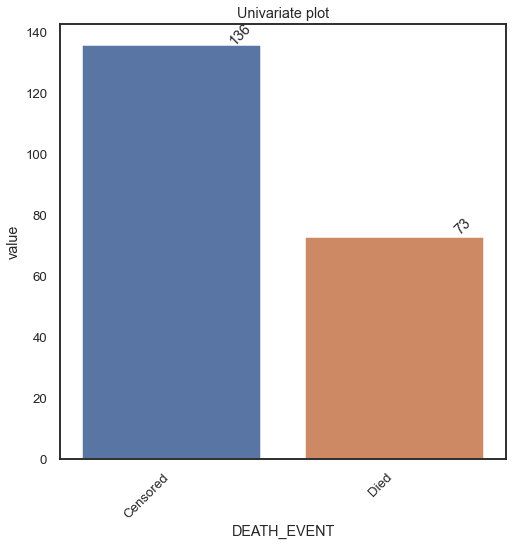

In [21]:
uni_categorical(df_exp, label='Y')

Most features are unbalanced.

Target feature 'DEATH_EVENT' have a high inbalance with most values being Censored.

### Checking numerical features


Exploratory Data Analysis

############### Univariate analysis - Numerical ###############



For normality tests of datasets with few variables, better perform a visual check,e.g: Q-Q plot.


For large datasets, you can present just a summary of normality tests and and other measures values by setting parameter just_summr="y".



 This is univariate analysis for ' age ' 


############### Summary ###############


,age
count,209.0
mean,60.94099
std,11.587332
min,40.0
25%,51.0
50%,60.0
75%,70.0
max,90.0
variance,134.266265
IQR,19.0



############### Normality tests ###############



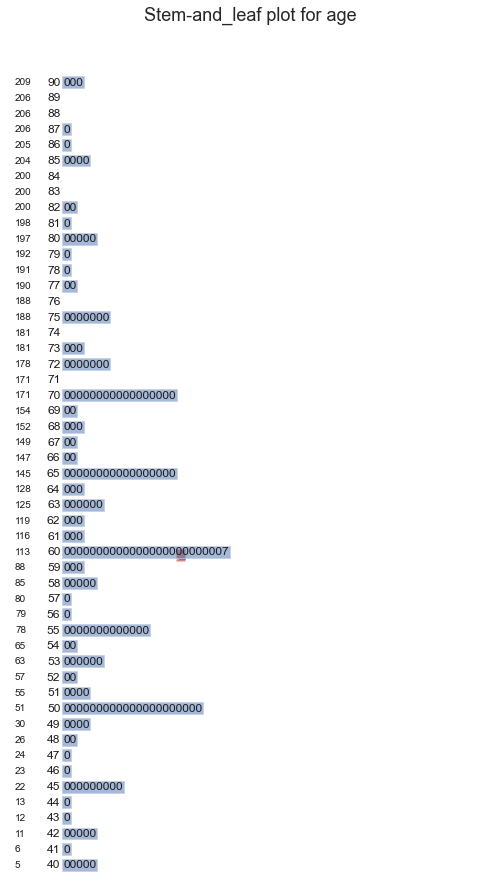

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

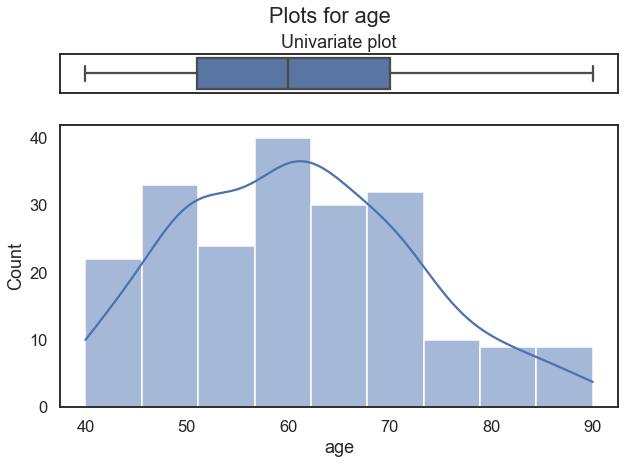

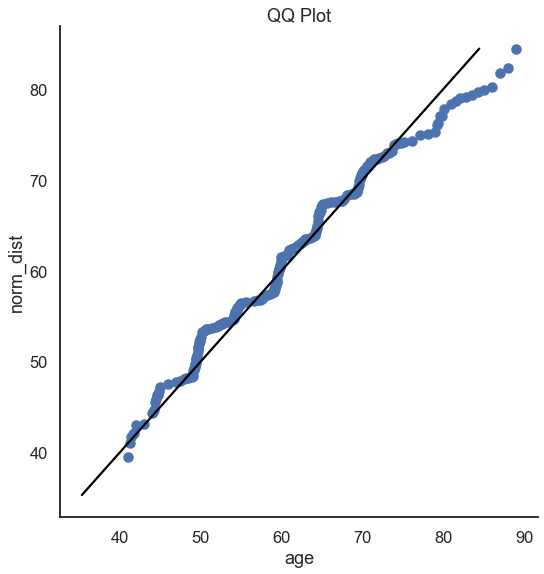

_____________________________________________________________________________



 This is univariate analysis for ' creatinine_phosphokinase ' 


############### Summary ###############


,creatinine_phosphokinase
count,209.0
mean,591.296651
std,1072.79492
min,23.0
25%,109.0
50%,235.0
75%,582.0
max,7861.0
variance,1150888.940421
IQR,473.0



############### Normality tests ###############



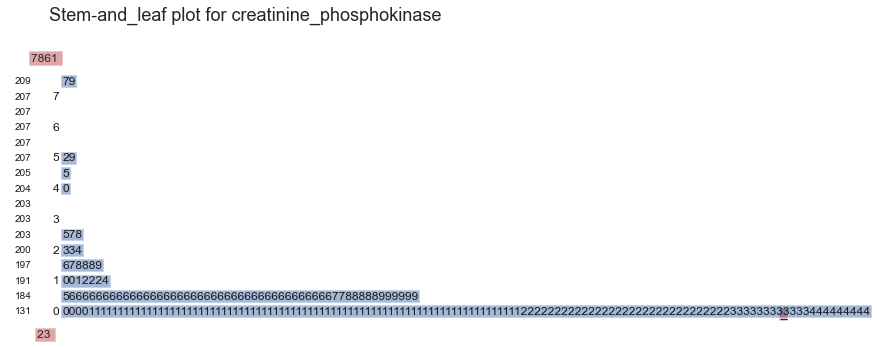

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

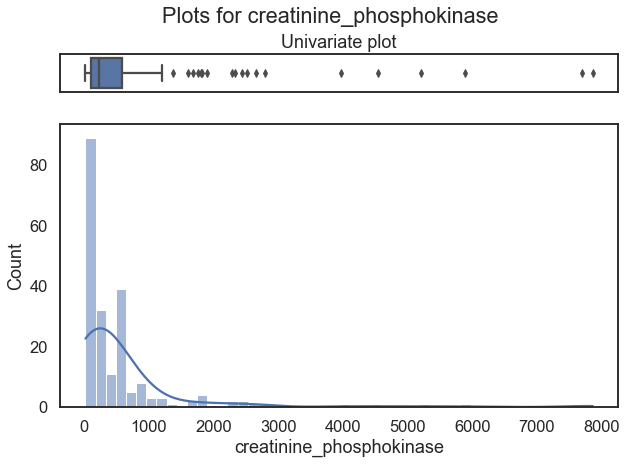

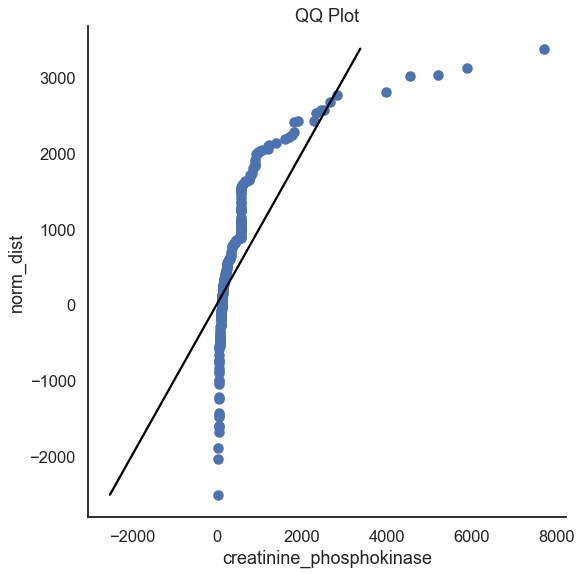

_____________________________________________________________________________



 This is univariate analysis for ' ejection_fraction ' 


############### Summary ###############


,ejection_fraction
count,209.0
mean,37.411483
std,11.6678
min,14.0
25%,30.0
50%,38.0
75%,45.0
max,70.0
variance,136.13756
IQR,15.0



############### Normality tests ###############



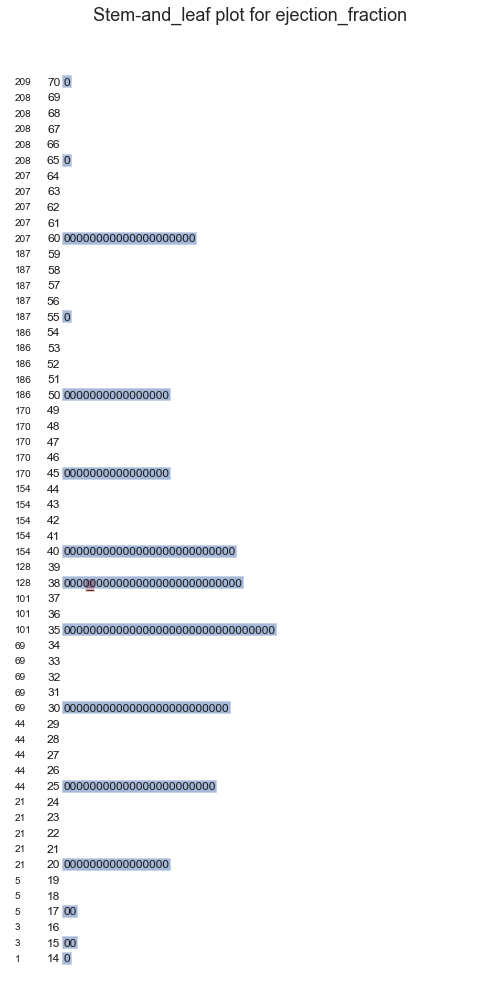

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

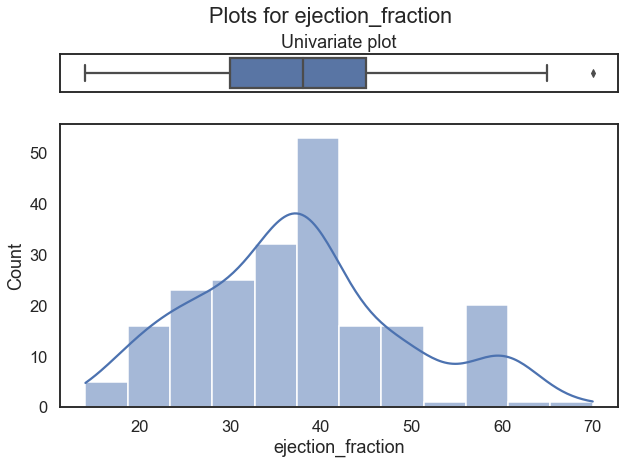

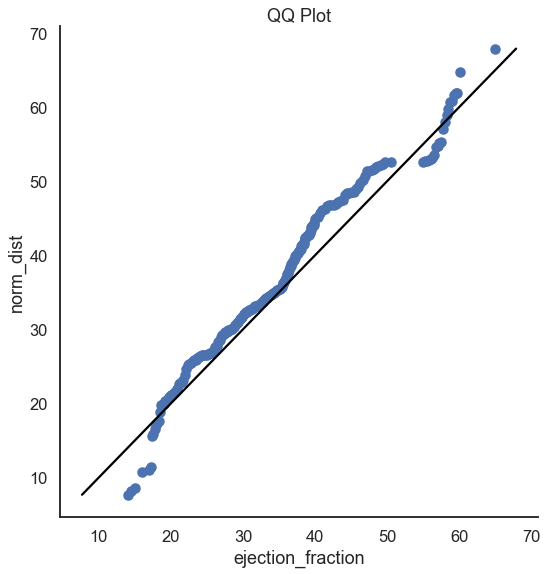

_____________________________________________________________________________



 This is univariate analysis for ' platelets ' 


############### Summary ###############


,platelets
count,209.0
mean,261030.83512
std,84551.244327
min,47000.0
25%,216000.0
50%,263358.03
75%,304000.0
max,621000.0
variance,7148912917.213915
IQR,88000.0



############### Normality tests ###############



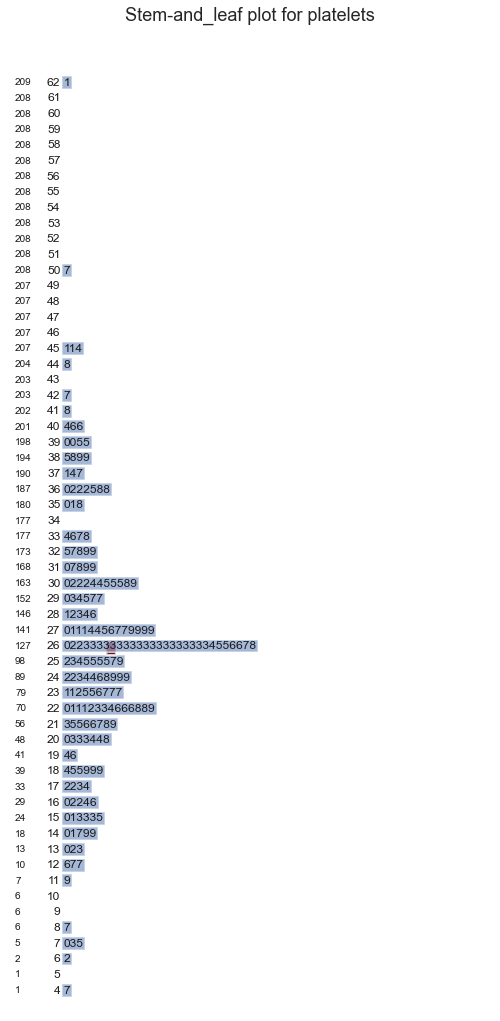

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

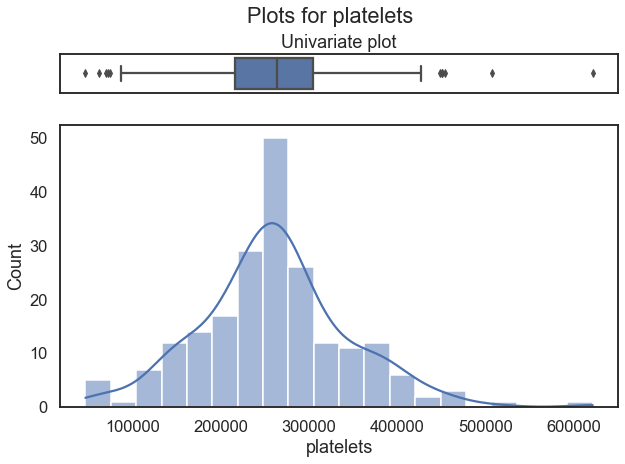

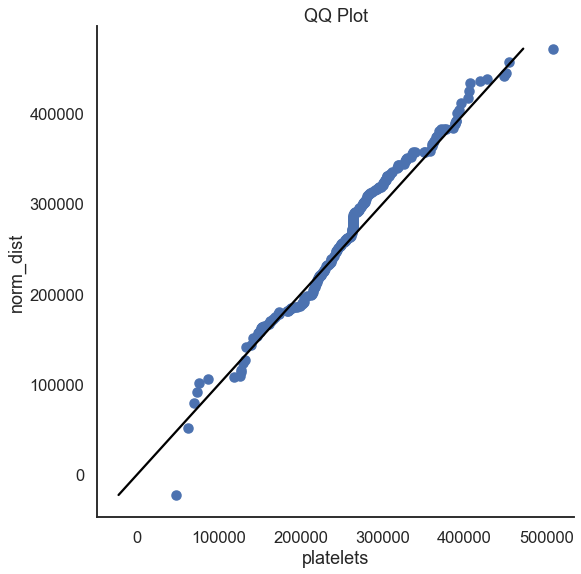

_____________________________________________________________________________



 This is univariate analysis for ' serum_creatinine ' 


############### Summary ###############


,serum_creatinine
count,209.0
mean,1.407081
std,1.042411
min,0.5
25%,0.9
50%,1.1
75%,1.5
max,9.4
variance,1.08662
IQR,0.6



############### Normality tests ###############



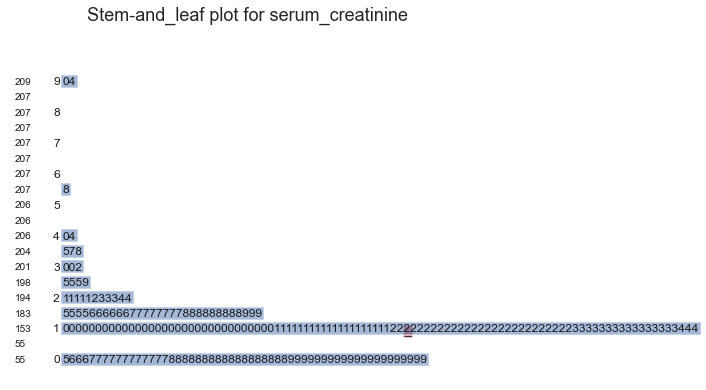

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

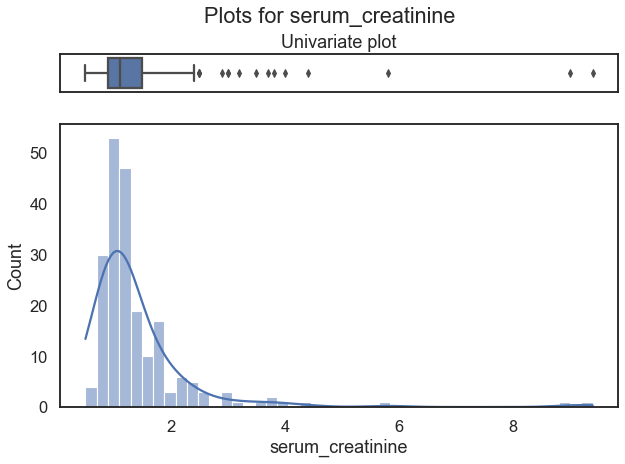

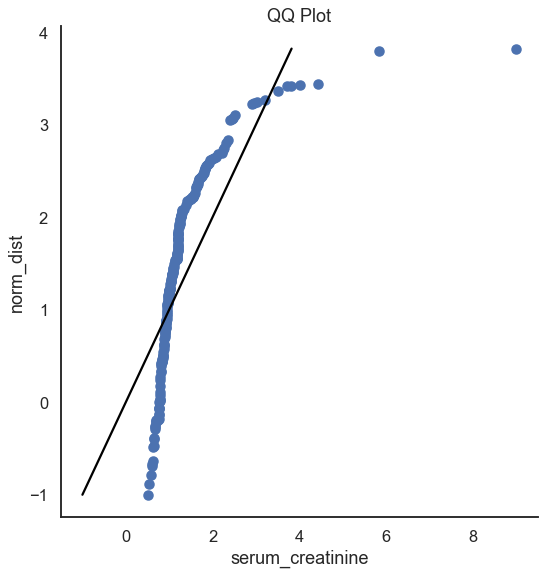

_____________________________________________________________________________



 This is univariate analysis for ' serum_sodium ' 


############### Summary ###############


,serum_sodium
count,209.0
mean,136.38756
std,4.403674
min,113.0
25%,134.0
50%,137.0
75%,140.0
max,148.0
variance,19.392344
IQR,6.0



############### Normality tests ###############



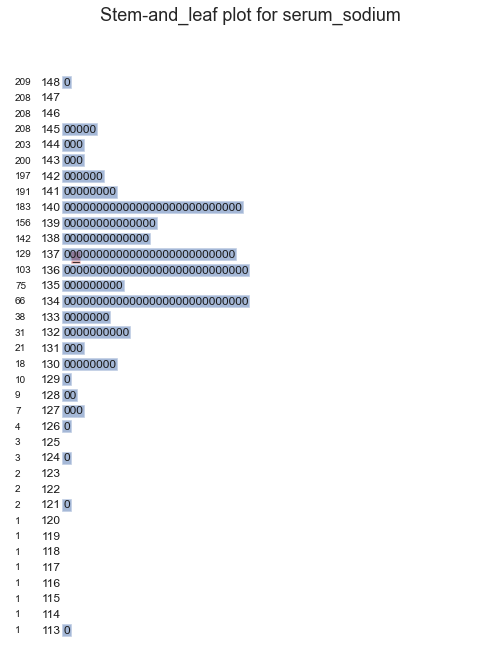

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

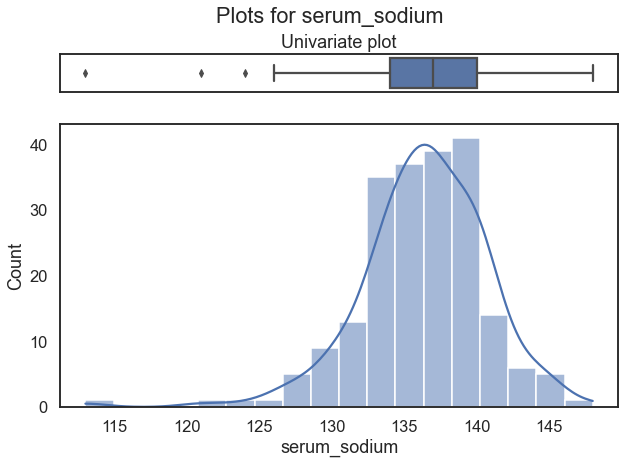

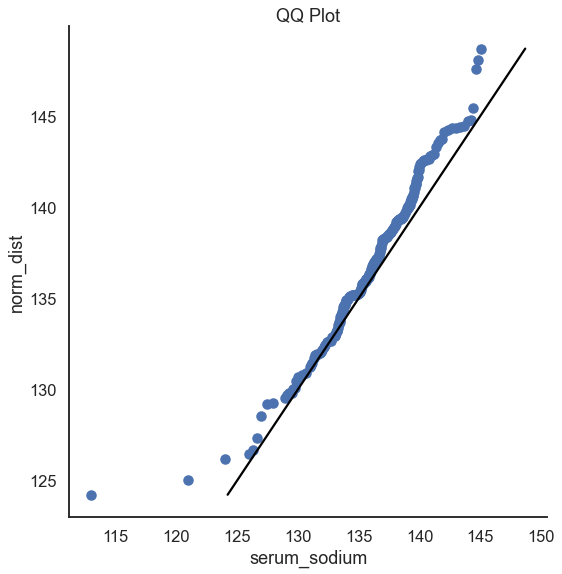

_____________________________________________________________________________



 This is univariate analysis for ' time ' 


############### Summary ###############


,time
count,209.0
mean,128.296651
std,77.255558
min,4.0
25%,72.0
50%,115.0
75%,196.0
max,285.0
variance,5968.421191
IQR,124.0



############### Normality tests ###############



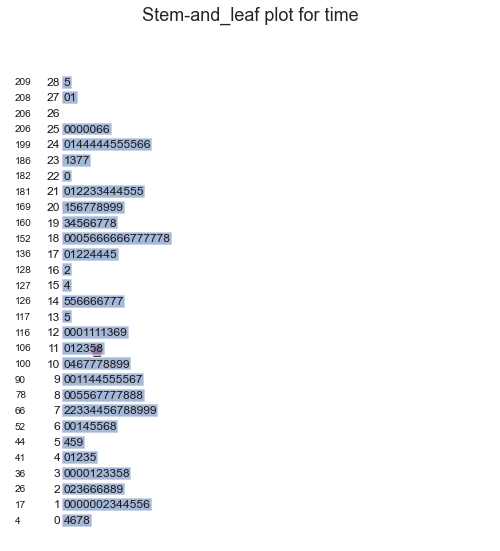

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

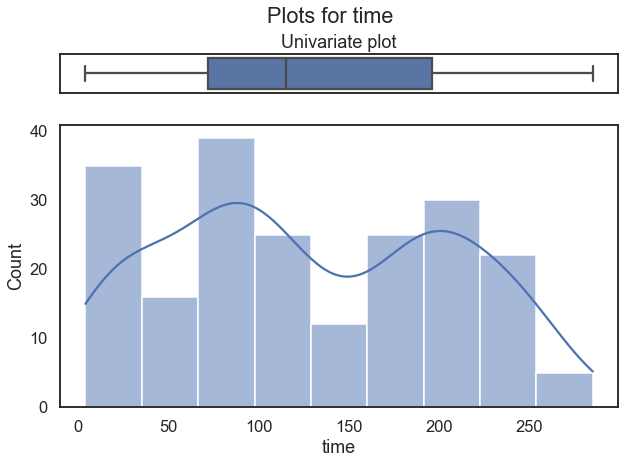

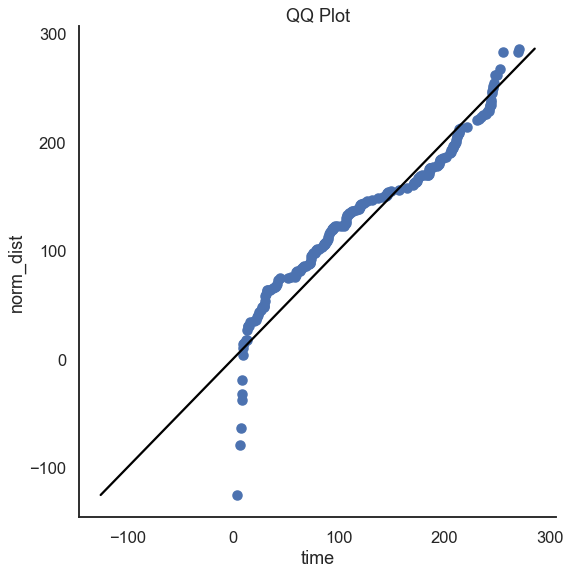

_____________________________________________________________________________



 This is univariate analysis for ' time ' 


############### Summary ###############


,time
count,209.0
mean,128.296651
std,77.255558
min,4.0
25%,72.0
50%,115.0
75%,196.0
max,285.0
variance,5968.421191
IQR,124.0



############### Normality tests ###############



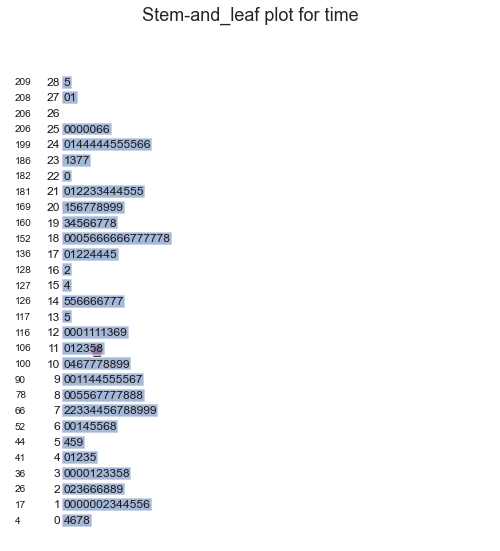

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, 
   or if the variable under consideration is discrete), the result will be (much) too liberal as the 
   large steps give an excessive

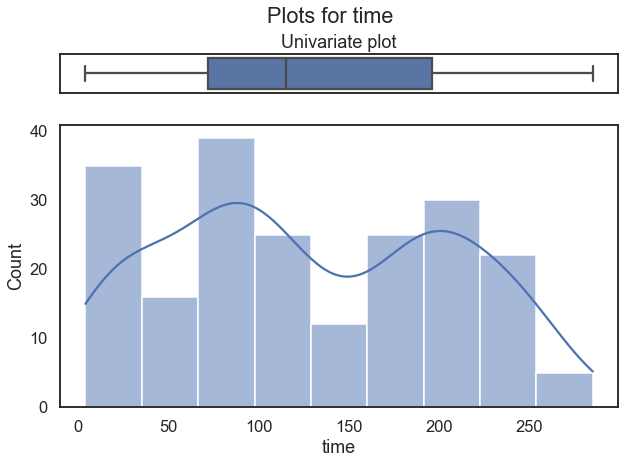

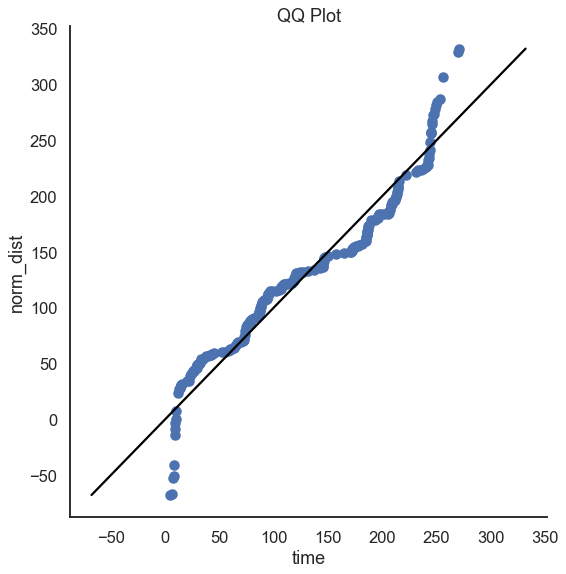

_____________________________________________________________________________


############### Summary ###############


Hypothesis:

H0: Sample may be Gaussian
H1: Sample does not looks Gaussian 
 
Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conservative, although Conover (1999) provides an equivalent approach for 
   discrete distributions for small samples.[Check Stem-and-leaf plot]
4. The sample distribution is assume

,features,count,mean,std,min,25%,50%,75%,max,variance,...,skewness,kurtosis,mode,Kolmogorov Statistics,Kolmogorov P-value,Anderson-Darling Statistics,Anderson-Darling Critical Value,Shapiro Statistics,Shapiro P-value,Defined Significance Level
0,age,209.0,60.940990,11.587332,40.0,51.0,60.00,70.0,90.0,1.342663e+02,...,0.319612,-0.406170,[60.0],1.000000,0.000000e+00,1.101944,0.773,0.977935,2.285168e-03,0.05
1,creatinine_phosphokinase,209.0,591.296651,1072.794920,23.0,109.0,235.00,582.0,7861.0,1.150889e+06,...,4.453275,23.346610,[582],1.000000,0.000000e+00,32.886283,0.773,0.481960,2.403748e-24,0.05
2,ejection_fraction,209.0,37.411483,11.667800,14.0,30.0,38.00,45.0,70.0,1.361376e+02,...,0.426359,-0.184003,[35],1.000000,0.000000e+00,3.203000,0.773,0.955397,4.120891e-06,0.05
3,platelets,209.0,261030.835120,84551.244327,47000.0,216000.0,263358.03,304000.0,621000.0,7.148913e+09,...,0.438300,1.388921,[263358.03],1.000000,0.000000e+00,1.514272,0.773,0.976477,1.425500e-03,0.05
4,serum_creatinine,209.0,1.407081,1.042411,0.5,0.9,1.10,1.5,9.4,1.086620e+00,...,4.818988,30.613856,[1.0],0.738898,1.183174e-117,23.905199,0.773,0.545015,4.884232e-23,0.05
5,serum_sodium,209.0,136.387560,4.403674,113.0,134.0,137.00,140.0,148.0,1.939234e+01,...,-0.978869,3.857175,"[134, 136]",1.000000,0.000000e+00,2.078870,0.773,0.945242,4.073649e-07,0.05
6,time,209.0,128.296651,77.255558,4.0,72.0,115.00,196.0,285.0,5.968421e+03,...,0.105028,-1.223545,"[10, 186]",0.999968,0.000000e+00,3.415042,0.773,0.945964,4.762598e-07,0.05


In [22]:
uni_numerical(df_exp,visual='Y',test='A',alpha=0.05)

Age looks normal shaped. Ejection fraction has a couple of outliers. Platelets, serum creatinine phosphokinase and serum creatinine have a great number of outliers observations.

# Development
## Next (immediate) phase:  

    Bivariate anaysis
    

### Bivariate analysis

#### Checking multicolilinearity

In [23]:
#Dropping target
df_exp.drop('DEATH_EVENT',axis=1,inplace=True)
#df_exp.columns

# Separting features by type: categorical and numerical
#numerical_columns = df_exp.select_dtypes(include=np.number) 
#categorical_columns = df_exp.select_dtypes(exclude=np.number) 

### Continuous x Continuous features

############### Bivariate analysis - Numerical x Numerical ###############

Pearson Correlation (how strong the correlation is?):
 Null hypothesis: there’s no association between variables.
	1.Normal distribution for both variables for pearson;
	2.homoscedasticity assumes that data is equally distributed about the regression line.
	3.Assess Linear relationship

Spearman rank Correlation (how strong the correlation is?):
 Null hypothesis: there’s no association between variables.
	1.Data must be at least ordinal;
	2.scores on one variable must be monotonically related to the other variable
	3.It's is appropriate for both continuous and discrete ordinal variables.
	4.Assess monotonic relationships.

Hoeffding's independence test(are the variables dependent?):
 Null hypothesis: there’s no association between variables.')
	1.continuous distribution functions;
	2. [...]the D statistic values are between –0.5 and 1, with 1 indicating complete dependence
	3. it has more power to detect non-mo

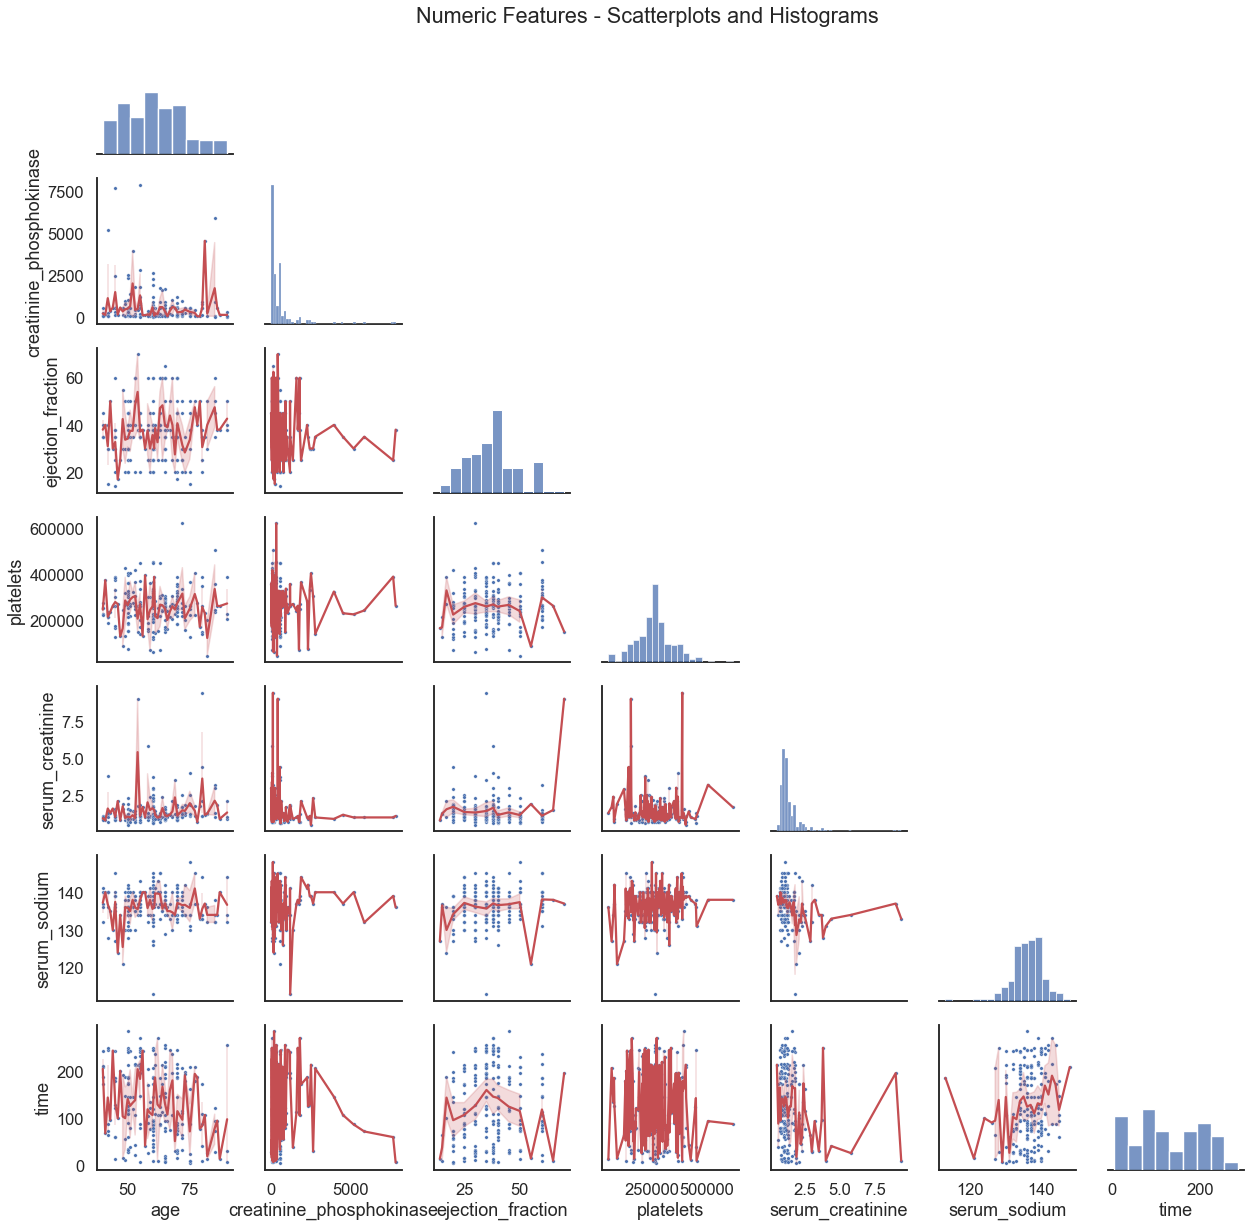

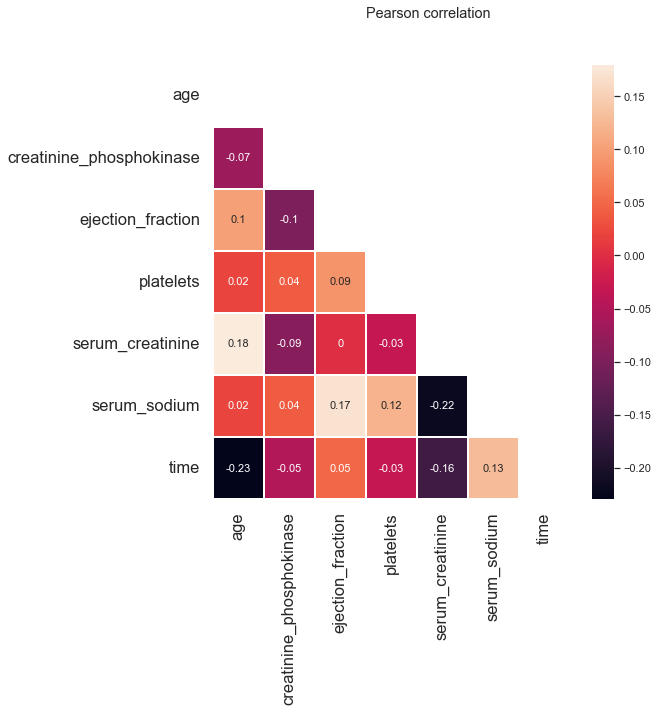

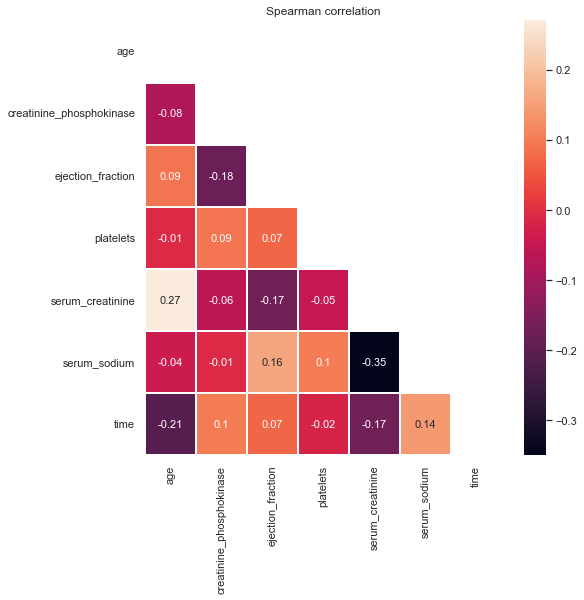

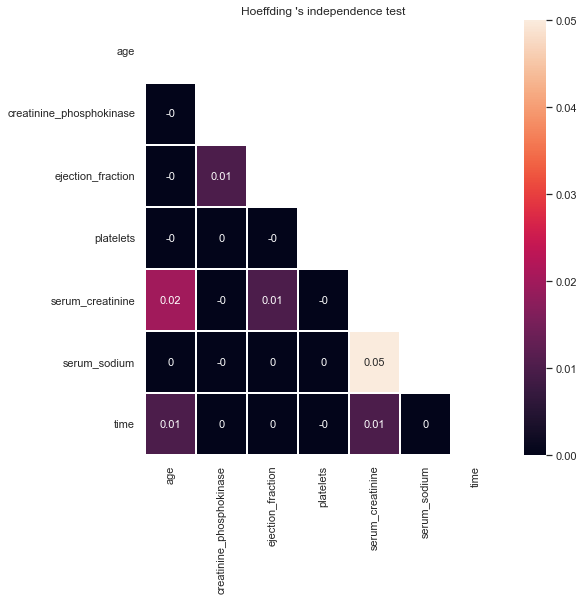

In [24]:
bi_numerical_num(df_exp)

We see that there's no indication of multicollinearity.

### Categorical x Categorical features


############### Bivariate analysis - Categorical x Categorical ###############

Chi-square tests, or similar resampling simulations, are used in data science applications more as a filter
	 to determine whether an effect or feature is worthy of further consideration than as a formal test of 
	 significance 
[...] 
They can also be used in automated feature selection in machine learning, to assess 
	 class prevalence  across features and identify features where the prevalence of a certain class is 
	 unusually high or low, in a way that is not compatible with random variation. 

Source: Practical Statistics for Data Scientists 
	 by Peter Bruce and Andrew Bruce 
	 Published by O’Reilly Media


This is contingency table for: anaemia and diabetes

 diabetes  No  Yes
anaemia          
No        70   48
Yes       54   37 



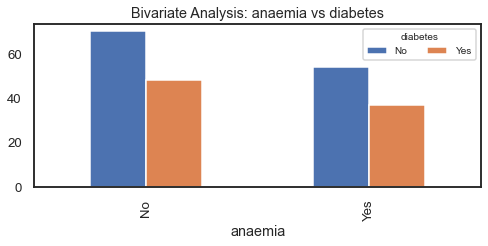


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  1.0 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: anaemia and high_blood_pressure

 high_blood_pressure  No  Yes
anaemia                     
No                   78   40
Yes                  60   31 



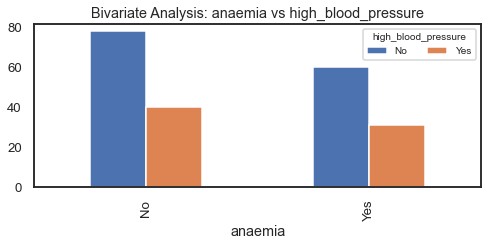


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  1.0 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: anaemia and sex

 sex      Female  Male
anaemia              
No           38    80
Yes          41    50 



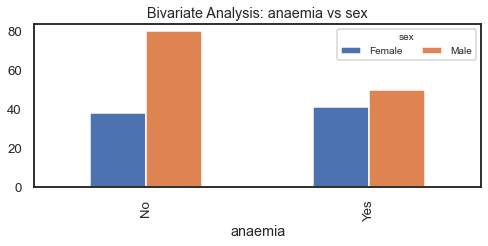


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.07910071692119039 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: anaemia and smoking

 smoking  No  Yes
anaemia         
No       75   43
Yes      68   23 



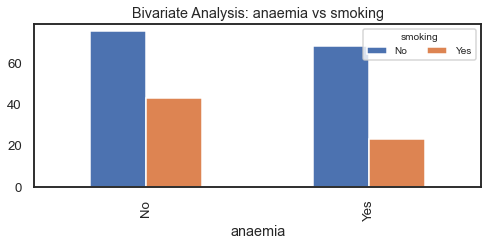


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.11600538970525921 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: diabetes and high_blood_pressure

 high_blood_pressure  No  Yes
diabetes                    
No                   81   43
Yes                  57   28 



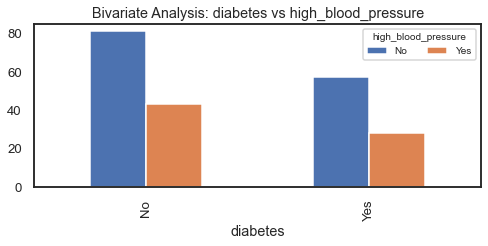


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.9110815477932668 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: diabetes and sex

 sex       Female  Male
diabetes              
No            39    85
Yes           40    45 



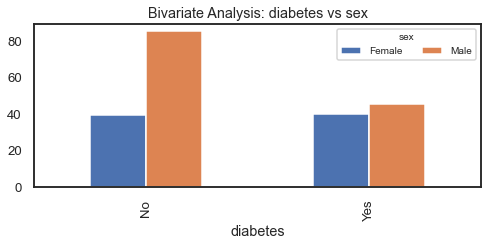


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.03230877638501783 

Reject Null Hypothesis. There's some correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: diabetes and smoking

 smoking   No  Yes
diabetes         
No        79   45
Yes       64   21 



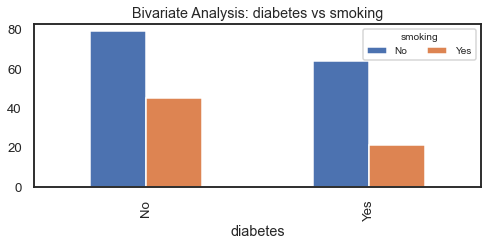


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.10558789211781708 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: high_blood_pressure and sex

 sex                  Female  Male
high_blood_pressure              
No                       48    90
Yes                      31    40 



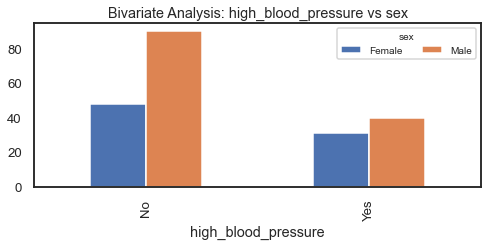


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.2699291319648077 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: high_blood_pressure and smoking

 smoking              No  Yes
high_blood_pressure         
No                   94   44
Yes                  49   22 



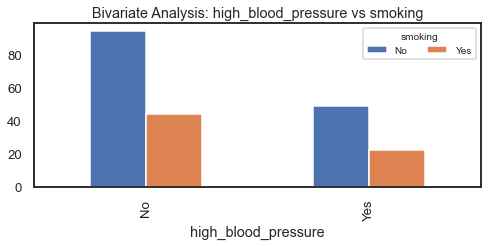


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  1.0 
 Fail to reject Null Hypothesis. There's no correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


This is contingency table for: sex and smoking

 smoking  No  Yes
sex             
Female   75    4
Male     68   62 



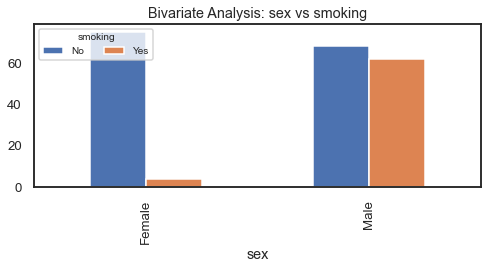


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  3.4905314997593186e-10 

Reject Null Hypothesis. There's some correlation between variables at  0.05  significance level.


__________________________________________________________________________________________


Summary of Results for Chi-Square test for Data set


,features,DOF,P values,Defined significance Level,Result
0,anaemia and diabetes,1,1.000000,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
1,anaemia and high_blood_pressure,1,1.000000,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
2,anaemia and sex,1,0.079101,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
3,anaemia and smoking,1,0.116005,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
4,diabetes and high_blood_pressure,1,0.911082,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
5,diabetes and sex,1,0.032309,0.050000,Reject Null Hypothesis. There's some correlation between variables
6,diabetes and smoking,1,0.105588,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
7,high_blood_pressure and sex,1,0.269929,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
8,high_blood_pressure and smoking,1,1.000000,0.050000,Fail to reject Null Hypothesis. There's no correlation between variables
9,sex and smoking,1,0.000000,0.050000,Reject Null Hypothesis. There's some correlation between variables


In [25]:
bi_categorical_cat(df_exp, alpha=0.05)

We see a couple of features: 'diabetes and sex' and 'sex and smoking' with indication of correlation.